In [63]:
from os import listdir
from os.path import isfile, join
from PIL import Image

import random
import math
import time
import numpy as np
import cv2

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import torchvision.models.segmentation
import torch
import torchvision.transforms as tf
import torch.nn as nn
import torch.nn.functional as F

In [64]:
width = 120
height = 120
numImg = 4

In [65]:
torch.cuda.is_available()

True

In [66]:
def LoadImg(path):
    image = Image.open(path)
    angle = path.split('_')[1]

    transformImg=tf.Compose([tf.ToPILImage(),tf.Resize((height,width)),tf.ToTensor(),tf.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]) 
    image=transformImg(np.array(image))

    if 'Real' in path:
        return image, -1000

    return image, float(angle)

In [67]:
def NormAngelToReal(normalisedAngle):
    return round((180*normalisedAngle)-90)

In [68]:
def LoadInferenceDisplay(model, realOrGeneratred):
    if realOrGeneratred == 'Real':
        fileArr = RealImages
    else:
        fileArr = GeneratedImages

    for img in fileArr:
        image, angle = LoadImg(img)

        #img = torch.autograd.Variable(image, requires_grad=False).to(device).unsqueeze(0) # Convert to pytorch
        image = image.to(device).unsqueeze(0)

        with torch.no_grad():
            prediction = model(image)  # Run net

        print('Image: ',img)
        print("Predicted Steering Angle: ", NormAngelToReal(prediction.data.cpu().numpy()[0][0]))
        if realOrGeneratred == 'Generated':
            print("Real Steering Angle: ", NormAngelToReal(angle))
            print("Error: ",NormAngelToReal(prediction.data.cpu().numpy()[0][0]) - NormAngelToReal(angle))
        print()


    cv2img= []
    for p in fileArr:
        cv2img.append(cv2.imread(p))

    f, axarr = plt.subplots(1,len(fileArr))
    for i in range(0,len(cv2img)):
        axarr[i].imshow(cv2img[i])

    plt.show()

In [69]:
class net(nn.Module):
    def __init__(self):
        super(net, self).__init__()
        self.fc = nn.Linear(512, 128)
        
        self.branch_a1 = nn.Linear(128, 32)
        self.branch_a2 = nn.Linear(32, 1)
    
    def forward(self, x):
        x = F.leaky_relu(self.fc(x))

        a = F.leaky_relu(self.branch_a1(x))
        
        out1 = self.branch_a2(a)
        
        return out1


# Set device GPU or CPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') 


#load net
#To Load Pretrained Weights:   weights='ResNet18_Weights.DEFAULT'
resnet18 = torchvision.models.resnet18()
resnet18.fc = nn.Identity()
net_add=net()
model = nn.Sequential(resnet18, net_add)

# load model to GPU
model = model.to(device)

modelPath = 'bestModel.torch'
model.load_state_dict(torch.load(modelPath))

model.eval()

Sequential(
  (0): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

In [70]:
pathGenerated = 'Generated'
filesGenerated = [f for f in listdir(pathGenerated) if isfile(join(pathGenerated, f))]

pathReal = 'Real'
filesReal = [f for f in listdir(pathReal) if isfile(join(pathReal, f))]

def LoadRandomImg(path, fileList):
    path = path + '/' + fileList[random.randrange(0,len(fileList))]
    return path

GeneratedImages = []
RealImages = []

for i in range(numImg):
    GeneratedImages.append(LoadRandomImg(pathGenerated, filesGenerated))
    RealImages.append(LoadRandomImg(pathReal, filesReal))


Image:  Generated/0degress0119_0.7556_degrees_x0y-3_crop.jpg
Predicted Steering Angle:  46
Real Steering Angle:  46
Error:  0

Image:  Generated/0degress0053_0.4056_degrees_x0y2_crop.jpg
Predicted Steering Angle:  -18
Real Steering Angle:  -17
Error:  -1

Image:  Generated/0degress0038_0.9556_degrees_x0y0_crop.jpg
Predicted Steering Angle:  82
Real Steering Angle:  82
Error:  0

Image:  Generated/0degress0048_0.7111_degrees_x0y2_crop.jpg
Predicted Steering Angle:  35
Real Steering Angle:  38
Error:  -3



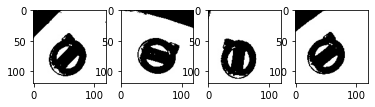

In [76]:
LoadInferenceDisplay(model, 'Generated')

Image:  Real/wheelCrop_angleNorm_0.5141873955726624_angleReal_2.5537312030792236.jpg
Predicted Steering Angle:  5

Image:  Real/wheelCrop_angleNorm_0.5107014775276184_angleReal_1.9262659549713135.jpg
Predicted Steering Angle:  0

Image:  Real/wheelCrop_angleNorm_0.421478271484375_angleReal_-14.1339111328125.jpg
Predicted Steering Angle:  -4

Image:  Real/wheelCrop_angleNorm_0.41255271434783936_angleReal_-15.740511417388916.jpg
Predicted Steering Angle:  -25



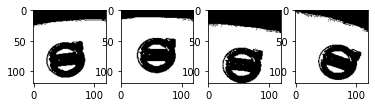

In [72]:
LoadInferenceDisplay(model, 'Real')

# LIME Testing

In [73]:
image, angle = LoadImg(GeneratedImages[0])

In [74]:
model

Sequential(
  (0): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

In [75]:
image = image.to(device).unsqueeze(0)

with torch.no_grad():
    prediction = model(image)  # Run net

predAngle = prediction.data.cpu().numpy()